In [1]:
from pyxtal import pyxtal

In [2]:
from mp_20_utils import load_all_data
dataset = "mp_20_biternary"
datasets_pd, torch_datasets, site_to_ids, element_to_ids, spacegroup_to_ids, max_len, max_enumeration, enumeration_stop, enumeration_pad = load_all_data(
    dataset=dataset)

In [3]:
import json
with open(f'generated_{dataset}.json') as f:
    generated_wychoffs = json.load(f)

In [4]:
from scipy.stats import wasserstein_distance, kstest

In [5]:
test_no_sites = datasets_pd['test'].symmetry_sites.map(len)
generated_no_sites = [sum(map(len, wygene['sites'])) for wygene in generated_wychoffs]

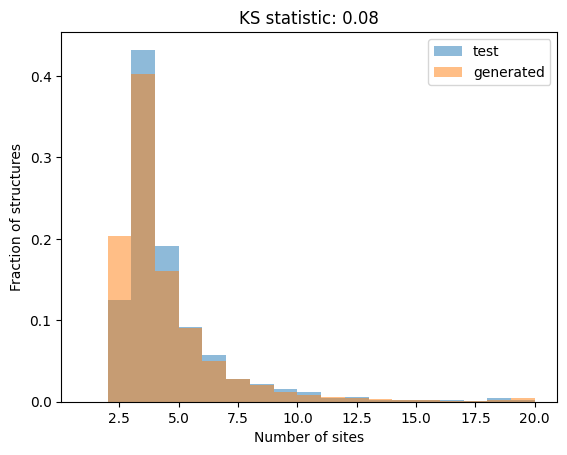

In [6]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
import numpy as np
bins = np.arange(1, max_len+1)
ax.hist(test_no_sites, bins=bins, alpha=0.5, label='test', density=True)
ax.hist(generated_no_sites, bins=bins, alpha=0.5, label='generated', density=True)
ax.set_xlabel('Number of sites')
ax.set_ylabel('Fraction of structures')
#ax.set_title(f"Wasserstein_distance: {wasserstein_distance(test_no_sites, generated_no_sites):.2f}")
ax.set_title(f"KS statistic: {kstest(test_no_sites, generated_no_sites).statistic:.2f}")
ax.legend();

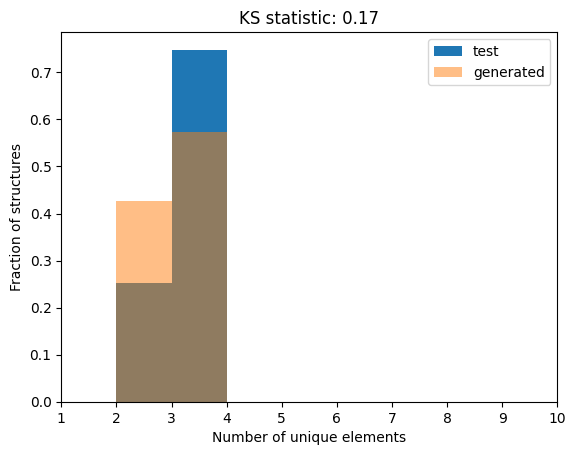

In [7]:
def count_elements(record):
    return len(set(record["elements"]))
def count_elements_pd(record):
    return len(set(record.structure.elements))
generated_no_elements = list(map(count_elements, generated_wychoffs))
test_no_elements = datasets_pd['test'].apply(count_elements_pd, axis=1)
fig, ax = plt.subplots()
bins = range(1, 10)
ax.hist(test_no_elements, label="test", density=True, bins=bins)
ax.hist(generated_no_elements, label="generated", density=True, alpha=0.5, bins=bins)
ax.set_xlabel("Number of unique elements")
ax.set_ylabel("Fraction of structures")
ax.legend()
#ax.set_title(f"Wasserstein distance: {wasserstein_distance(test_no_elements, generated_no_elements):.2f}")
ax.set_title(f"KS statistic: {kstest(test_no_elements, generated_no_elements).statistic:.2f}")
ax.set_xlim((1,10));

In [8]:
import pickle
with open("wychoffs_enumerated_by_ss.pkl.gz", "rb") as f:
    a, letter_from_ss_enum, ss_from_letter = pickle.load(f)
def extract_ss(wychoff_gene):
    res = []
    for sites_list in wychoff_gene['sites']:
        res.extend([ss_from_letter[wychoff_gene['spacegroup']][multi_letter.lstrip("1234567890")] for multi_letter in sites_list])
    return res

In [9]:
from collections import Counter
from itertools import chain
test_ss_frequency = Counter(chain(*datasets_pd['test']['symmetry_sites']))
generated_ss_frequency = Counter(chain(*map(extract_ss, generated_wychoffs)))

In [10]:
# Compute chi2 distance test_ss_frequency and generated_ss_frequency
import numpy as np
def counter_to_vector(counter):
    res = np.zeros(len(site_to_ids))
    for ss, ss_id in site_to_ids.items():
        res[ss_id] = counter[ss]
    return res

In [11]:
test_ss_frequency_np = counter_to_vector(test_ss_frequency)
generated_ss_frequency_np = counter_to_vector(generated_ss_frequency)

In [12]:
exclusion_mask = ~((test_ss_frequency_np == 0) | (generated_ss_frequency_np == 0))

In [13]:
id_to_ss = {v: k for k, v in site_to_ids.items()}

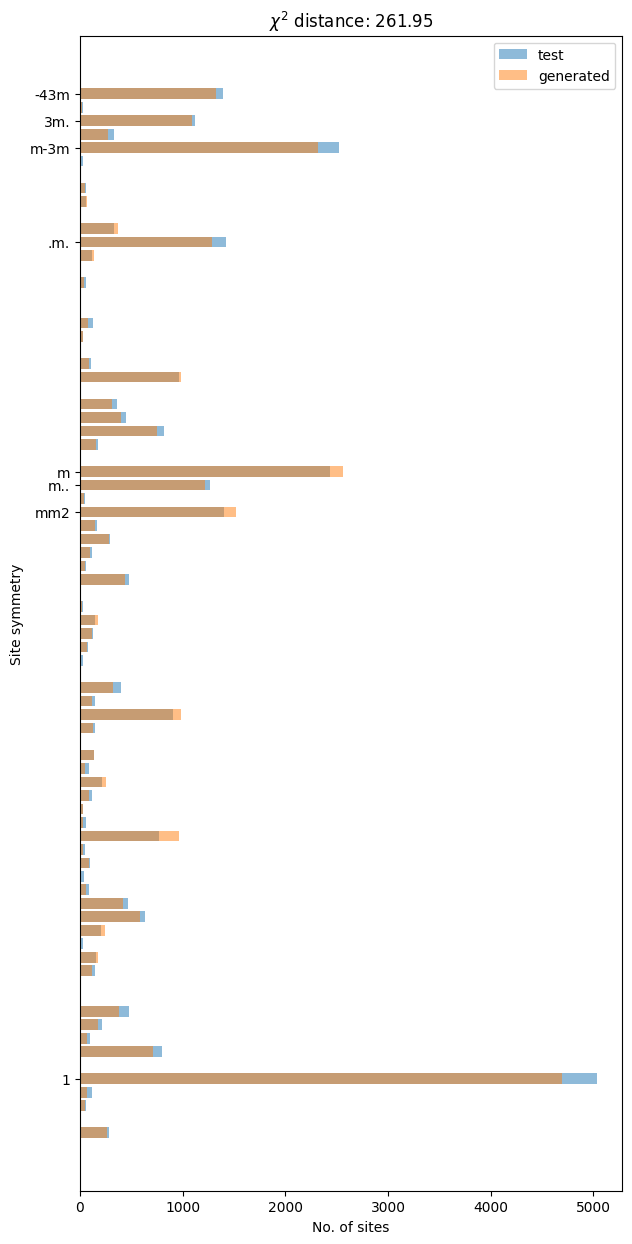

In [14]:
from scipy.stats import chi2_contingency
chi2_results = chi2_contingency(np.vstack([test_ss_frequency_np[exclusion_mask], generated_ss_frequency_np[exclusion_mask]]))
fig, ax = plt.subplots(figsize=(7, 15))
ax.barh(range(len(site_to_ids)), test_ss_frequency_np, alpha=0.5, label='test')
ax.barh(range(len(site_to_ids)), generated_ss_frequency_np, alpha=0.5, label='generated')
ax.set_xlabel('No. of sites')
ax.set_ylabel('Site symmetry');
ax.set_title(f"$\\chi^2$ distance: {chi2_results[0]:.2f}")
high_bins = test_ss_frequency_np > 1000
ax.set_yticks(np.nonzero(high_bins)[0])
ax.set_yticklabels([id_to_ss[i] for i in np.nonzero(high_bins)[0]])
ax.legend();

In [15]:
test_elements_count = Counter()
for element, mutliplicity in zip(chain(*datasets_pd['test']['symmetry_elements']),
                                 chain(*datasets_pd['test']['symmetry_multiplicity'])):
    test_elements_count[element] += mutliplicity

In [16]:
from pymatgen.core import Element
generated_elements_count = Counter()
for wychoff_gene in generated_wychoffs:
    for element, multiplicity in zip(wychoff_gene['elements'], wychoff_gene['composition']):
        generated_elements_count[Element(element)] += multiplicity

In [17]:
test_elements_count_np = np.array([test_elements_count[element] for element in element_to_ids])
generated_elements_count_np = np.array([generated_elements_count[element] for element in element_to_ids])
exclusion_mask = ~((test_elements_count_np == 0) | (generated_elements_count_np == 0))
chi2_results = chi2_contingency(np.vstack([test_elements_count_np[exclusion_mask], generated_elements_count_np[exclusion_mask]]))

In [18]:
id_to_element = {v: k for k, v in element_to_ids.items()}

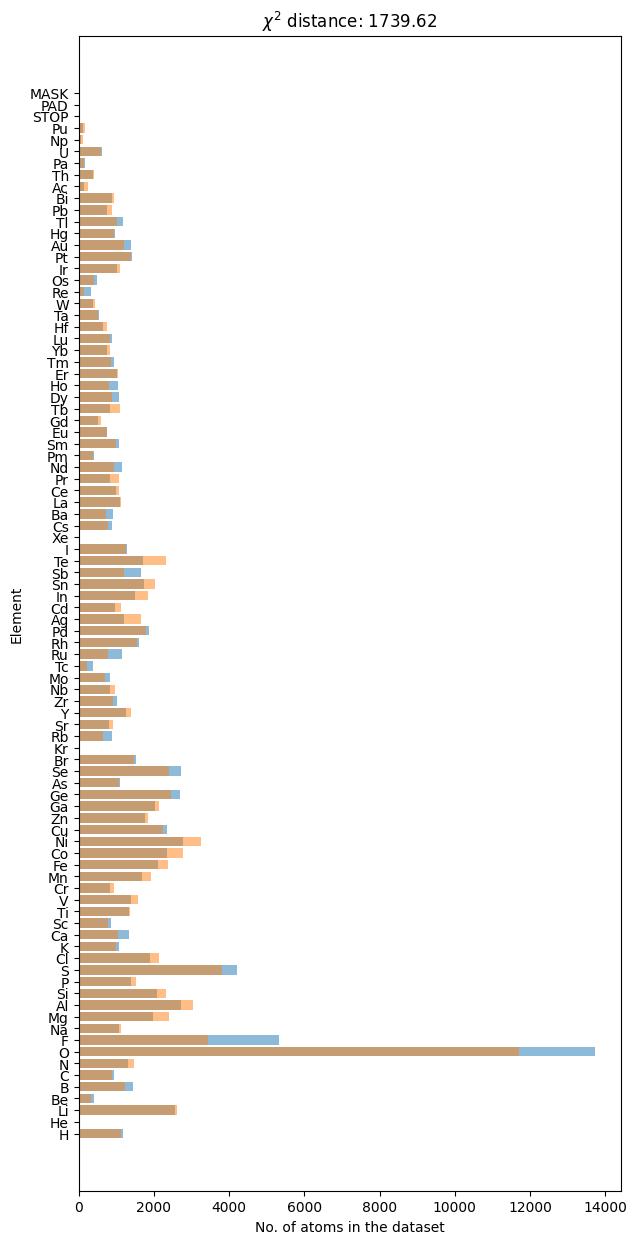

In [19]:
fig, ax = plt.subplots(figsize=(7, 15))
ax.barh(range(len(element_to_ids)), test_elements_count_np, alpha=0.5, label='test')
ax.barh(range(len(element_to_ids)), generated_elements_count_np, alpha=0.5, label='generated')
ax.set_xlabel('No. of atoms in the dataset')
ax.set_ylabel('Element')
ax.set_title(f"$\\chi^2$ distance: {chi2_results[0]:.2f}")
high_count = -1
high_bins = test_elements_count_np > high_count
ticks = np.nonzero(high_bins)[0]
ax.set_yticks(ticks)
ax.set_yticklabels([id_to_element[i] for i in ticks]);

In [20]:
element_ss_matrix = np.zeros((len(element_to_ids), len(site_to_ids)))
for wychoff_gene in generated_wychoffs:
    for element, sites in zip(wychoff_gene['elements'], wychoff_gene['sites']):
        for site in sites:
            ss = ss_from_letter[wychoff_gene['spacegroup']][site.lstrip("1234567890")]
            element_ss_matrix[element_to_ids[Element[element]], site_to_ids[ss]] += 1

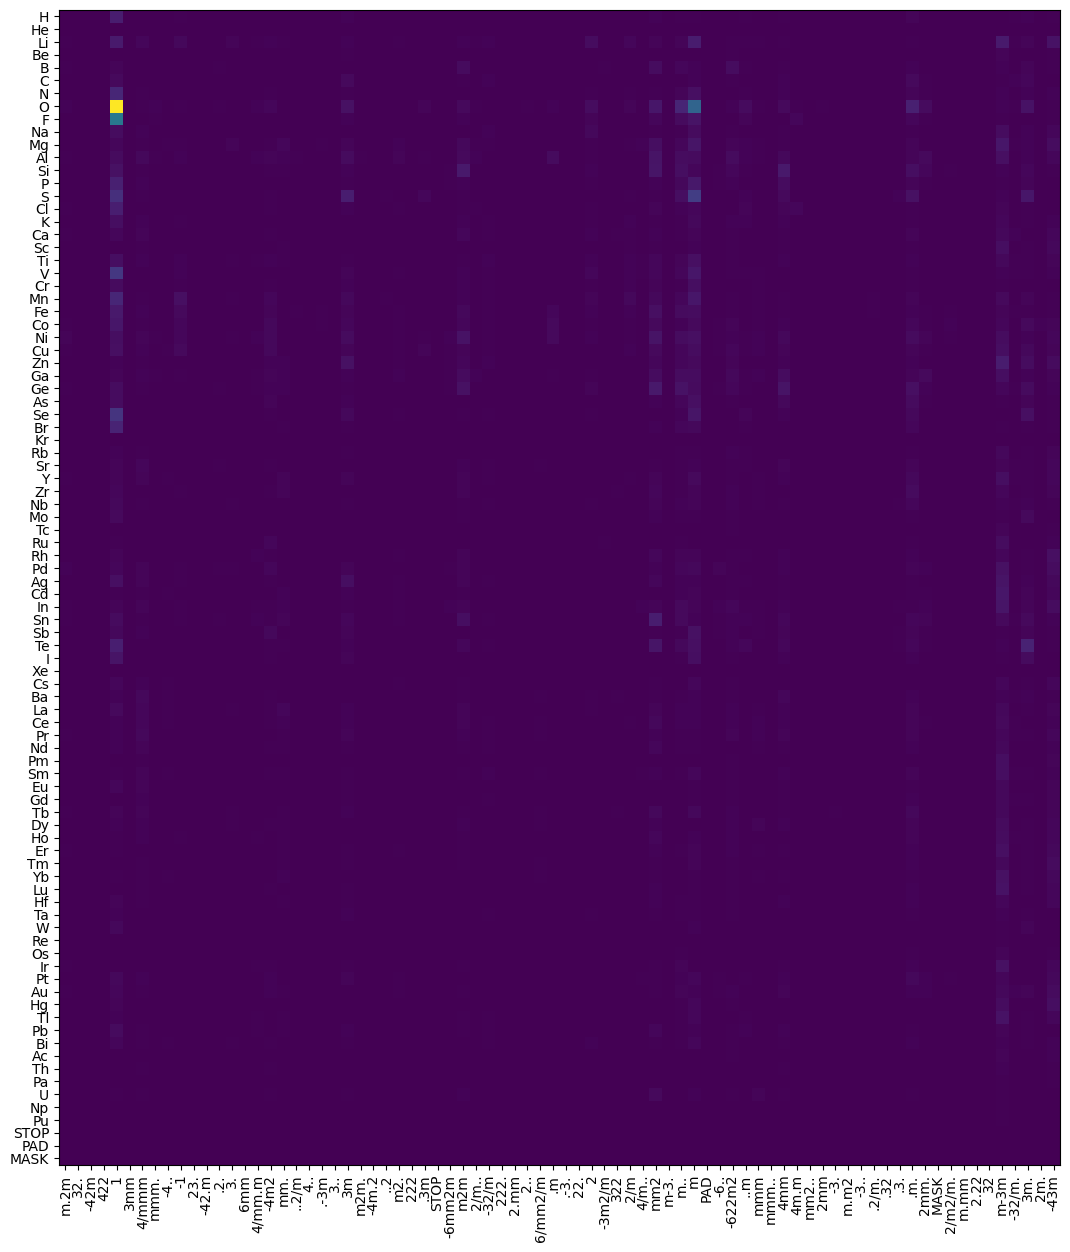

In [21]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(element_ss_matrix, cmap='viridis')
ax.set_xticks(range(len(site_to_ids)))
ax.set_xticklabels([id_to_ss[i] for i in range(len(site_to_ids))], rotation=90);
ax.set_yticks(range(len(element_to_ids)))
ax.set_yticklabels([id_to_element[i] for i in range(len(element_to_ids))]);

In [22]:
from collections import defaultdict
from pyxtal.symmetry import Group
dof_from_letter = defaultdict(dict)
for group_number in range(1, 231):
    group = Group(group_number)
    for wp in group.Wyckoff_positions:
        wp.get_site_symmetry()
        dof_from_letter[group_number][wp.letter] = wp.get_dof()

In [23]:
def get_total_dof(wychoff_gene):
    dof = sum(map(lambda site: dof_from_letter[wychoff_gene['spacegroup']][site.lstrip('1234567890')],
                  chain(*wychoff_gene['sites'])))
    return dof

In [24]:
generated_dof = np.array([get_total_dof(wg) for wg in generated_wychoffs])

In [25]:
test_dof = datasets_pd['test']['symmetry_dof'].apply(sum)

In [26]:
test_dof.min()

0

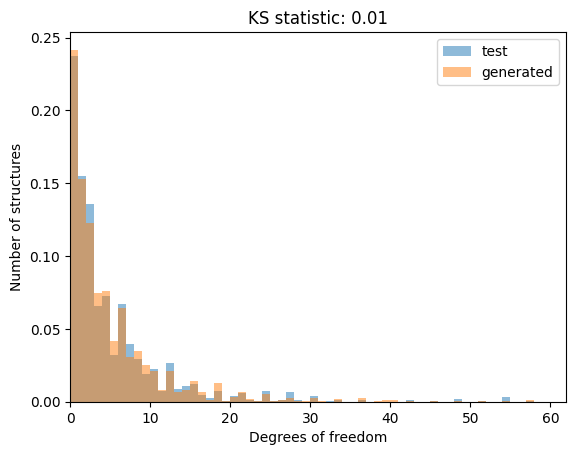

In [27]:
fig, ax = plt.subplots()
bins=range(test_dof.max())
ax.hist(test_dof, bins=bins, alpha=0.5, label='test', density=True)
ax.hist(generated_dof, bins=bins, alpha=0.5, label='generated', density=True)
ax.set_xlabel('Degrees of freedom')
ax.set_ylabel('Number of structures')
ax.set_title(f"KS statistic: {kstest(test_dof, generated_dof).statistic:.2f}")
ax.legend()
ax.set_xlim(0);